# 1. Markov Decision Processes (MDP) $\langle S, A, R, P, P_0, H, \gamma\rangle$

$S$ a set of states.\
$A$ a set of actions.\
$R$ a reward mapping : $S \times A \rightarrow \mathbb{R}$.\
$P$ the transition probability distribution $S \times A \rightarrow \Delta S$.\
$P_0$ the initial distribution over states: $s_0 \in S \sim P_0$.\
$H$ the horizon: the number of transition per episode.\
$\gamma$ the discount factor in $(0,1)$.

MDPs are used to model sequential decision tasks in which at each time step $t$, an agent has to take an action given its current state. From $t=0$ to $t=H$, an agent observes state $s_t$ and takes action $a_t$. The agent then transitions to $s_{t+1}$ with probability $P(s_{t+1}|s_t, a_t)$ and receives reward $r_t = R(s_t,a_t,s_{t+1})$. At $t=0$, the agent "spawns" in an initial state $s_0$ with probability $P_0(s_0)$. One can also define terminal states that are such that an agent will not take actions in those states: in such terminal states the MDP stops even though $t<H$. An episode or a trajectory in a MDP, is a sequence of length at most $H$ of transition tuples ($s_t, a_t, r_t, s_{t+1}$).

With Dynamic Programming or Reinforcement Learning, it is possible to train agents in MDPs in order to learn good solutions for sequential decision tasks. Such solutions are called policies and are mappings from actions to distributions over actions: $\Pi: S \rightarrow \Delta A$. The goal of Dynamic Programming and RL is to find the optimal policy $\pi^* = \underset{\pi \in \Pi}{\operatorname{argmax}} \underset{s_0 \sim P_0,a_t \sim \pi(s_t),s_{t+1}\sim P(s_t, a_t)}{\mathbb{E}}\left [ \underset{t=0}{\overset{H}{\sum}}\gamma^t R(s_t, a_t)\right ]$. The latter objective function finds policies that maximize the expected cumulative reward of the MDP: we want to find a policy that will, in expectation, generate MDP episodes with high rewards!

## 1.1 Exercise 1: Implement a Markov Decision Process class

In the exercises, we will consider that states and actions are finite: $|S| < \infty, |A| < \infty $. For such discrete MDPs, the optimal policy is deterministic i.e $\pi^*: S \rightarrow A$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Mdp:
    """
    Defines a Markov Decision Process
    """
    def __init__(
        self,
        states: list,
        actions: list,
        initial_distribution: np.array,  # P0
        transition_probability: np.array,  # P
        reward_function: np.array,  # R
        gamma: float = 0.9,
        terminal_states: list = [],
        horizon: int = 50,
    ):
        self.states = states
        self.nb_states = len(states)
        self.terminal_states = terminal_states

        self.actions = actions
        self.nb_actions = len(actions)

        self.P = transition_probability
        self.P0 = initial_distribution

        self.R = reward_function

        self.horizon = horizon
        self.gamma = gamma

        self.timestep = 0
        self.current_state = None

        assert self.check_P_is_distrib(), "transition matrix is not a valid distribution"
        assert self.check_P0_is_distrib(), "initial distribution is not valid"

    def check_P_is_distrib(self):
        """Check that P sums to 1 over next states for all (s,a) pairs"""
        # Check values are in [0, 1]
        if not np.all((self.P >= 0) & (self.P <= 1)):
            return False
        # Check sums to 1 for each (s, a) pair
        return np.allclose(np.sum(self.P, axis=2), np.ones((self.nb_states, self.nb_actions)))

    def check_P0_is_distrib(self):
        """Check that P0 sums to 1"""
        return np.all((self.P0 >= 0) & (self.P0 <= 1)) and np.isclose(np.sum(self.P0), 1.0)

    def reset(self):
        """Initialize an episode and return the initial state"""
        self.current_state = np.random.choice(a=self.states, p=self.P0)
        self.timestep = 0
        return self.current_state

    def done(self):
        """Check if episode is over"""
        return self.timestep >= self.horizon or self.current_state in self.terminal_states

    def step(self, a):
        """Perform a transition in the MDP"""
        # Sample next state
        next_state = np.random.choice(a=self.states, p=self.P[self.current_state, a])
        # Get reward
        reward = self.R[self.current_state, a, next_state]

        # Update state
        self.timestep += 1
        self.current_state = next_state
        done = self.done()

        return next_state, reward, done

    def one_episode(self, policy):
        """Run one episode following a given policy"""
        state = self.reset()
        done = False
        score = 0
        while not done:
            action = policy(state)
            next_state, r, done = self.step(action)
            score += r
            state = next_state
        return score


## 1.2 Exercise 2: Model the blackjack with dice game using your MDP class and evaluate the performances of simple policies.

In blackjack with a die, the goal is to throw as many dice as one wants, sequentially, in order to obtain a sum of dice as close as possible to 21. Take your time to model the problem.

An episode, i.e a single blackjack with a die game, looks like this: agent throws a die, checks the result, decides to throw again or not, if it threw, checks the sum of dice and repeat, else, the game is over. The score of the agent is the final sum of the dice (or 0, if the sum is strictly greater than 21).

- What should the states be?
- What does the probability transition matrix look like?
- Are there terminal transitions?
- What is the reward at time $t$ if the agent score is the *final* sum of dice?

In [3]:
### BLACKJACK WITH DICE ###
S = np.arange(23)  # s=0: initial, s=1..21: dice sums, s=22: terminal (bust or stop)
A = [0, 1]  # 0: stop, 1: throw

# Initial distribution: always start at s=0
P0 = np.zeros(len(S))
P0[0] = 1

# Transition probabilities P[s, a, s_next]
P = np.zeros((len(S), len(A), len(S)))

for s in S:
    if s == 22:  # Terminal state
        # Stay in terminal state (for valid probability distribution)
        P[s, :, 22] = 1
    else:
        # Action 0: stop throwing -> go to terminal state
        P[s, 0, 22] = 1

        # Action 1: throw a die
        if s == 0:
            # First throw: get 1-6 with probability 1/6 each
            P[s, 1, 1:7] = 1/6
        else:
            # Subsequent throws: add 1-6 to current sum
            for dice_value in range(1, 7):
                next_sum = s + dice_value
                if next_sum > 21:
                    # Bust: go to terminal state
                    P[s, 1, 22] += 1/6
                else:
                    # Valid sum
                    P[s, 1, next_sum] = 1/6

# Reward function R[s, a, s_next]
R = np.zeros((len(S), len(A), len(S)))
for s in S:
    # When stopping: reward is the current sum (unless terminal or 0)
    if s < 22:
        R[s, 0, :] = s
    # When throwing: no immediate reward
    R[s, 1, :] = 0

blackjack_dice = Mdp(S, A, P0, P, R, terminal_states=[22])


A simple class for policies (a policy $\pi$ takes a state $s$ and returns an action $a$).

In [4]:
class Policy:
    def __init__(self, mdp:Mdp):
        self.mdp = mdp

    def get_action(self, state):
        raise NotImplementedError

class Uniform(Policy):
    def __init__(self, mdp:Mdp):
        super().__init__(mdp)

    def get_action(self, state):
        return np.random.randint(self.mdp.nb_actions)

Implement a simple policy that throws a die only if the score is below 16.

In [5]:
class ThresholdPolicy(Policy):
    def __init__(self, mdp):
        super().__init__(mdp)

    def get_action(self, state):
        return 1 if state < 15 else 0  # 1: throw, 0: stop


In [6]:
pol_unif = Uniform(blackjack_dice).get_action
# Let us check the average performance of the random policy on 100 blackjack with dice games.
policy_unif_eval = []
for episodes in range(100):
    policy_unif_eval.append(blackjack_dice.one_episode(pol_unif))

pol_thresh = ThresholdPolicy(blackjack_dice).get_action
# Let us check the average performance of the threshold policy on 100 blackjack with dice games.
policy_thresh_eval = []
for episodes in range(100):
    policy_thresh_eval.append(blackjack_dice.one_episode(pol_thresh))


print("mean +- std of the score of the uniform policy: {} +/- {}".format(np.mean(policy_unif_eval), np.std(policy_unif_eval)))
print("mean +- std of the score of the threshold policy: {} +/- {}".format(np.mean(policy_thresh_eval), np.std(policy_thresh_eval)))


mean +- std of the score of the uniform policy: 3.78 +/- 4.855059216940614
mean +- std of the score of the threshold policy: 16.58 +/- 1.524335920983298


# 2. Dynamic Programming

## 2.1 State value function $V^{\pi}(s)$

One way to find the optimal policy for a MDP is to find the states with highest value, then $\pi^*$ is the policy that visits those states. The value of a state, given a policy $\pi$, is the expected cumulative reward obtained by $\pi$ over MDP episodes when starting the episodes in $s_0 = s$. It is defined as follows with the Bellman expectation equation:

$V^{\pi}(s) = \underset{s'\in S}{\sum} P(s'|s, \pi(s))(R(s, \pi(s), s') + \gamma V^{\pi}(s'))$

The value of state $s$ is simply the reward obtained by $\pi$ in state $s$, plus the value of the expected next state $s'$.

## 2.2 Exercise 3: Implement the Value Iteration algorithm

The Bellman optimality equation defines an algorithm to find the value function associated with the optimal policy.

$V^*(s) = \underset{a}{\operatorname{max}}\left [ \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma V^{*}(s'))\right]$

[The Value Iteration algorithm](http://incompleteideas.net/book/ebook/node44.html)

In [7]:
def VI(mdp, eps=1e-2):
    """Value Iteration algorithm"""
    V = np.zeros(mdp.nb_states)
    list_error = []

    converged = False
    while not converged:
        V_old = V.copy()

        for s in mdp.states:
            if s in mdp.terminal_states:
                continue

            # Compute value for each action
            action_values = []
            for a in mdp.actions:
                # Expected value: sum over next states
                value = 0
                for s_next in mdp.states:
                    value += mdp.P[s, a, s_next] * (mdp.R[s, a, s_next] + mdp.gamma * V_old[s_next])
                action_values.append(value)

            # Take maximum over actions
            V[s] = np.max(action_values)

        # Check convergence
        error = np.linalg.norm(V - V_old)
        list_error.append(error)
        if error < eps:
            converged = True

    return V, list_error


Run VI on the blackjack with dice MDP and plot the convergence of the algorithm for different thresholds $\epsilon$.

Optimal Value Function:
[10.42598277 10.74032638 11.06744805 11.40977287 11.74671306 12.09086333
 12.45162383 12.83581963 13.24821272 13.69192411 13.99297748 14.38519781
 14.85669375 15.397125   15.9975     16.65       16.         17.
 18.         19.         20.         21.          0.        ]


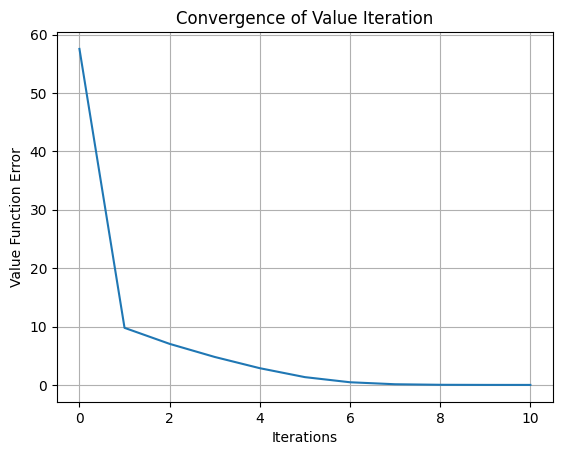

In [8]:
V, list_error = VI(blackjack_dice, eps=0.001)
print("Optimal Value Function:")
print(V)
plt.plot(list_error)
plt.xlabel('Iterations')
plt.ylabel('Value Function Error')
plt.title('Convergence of Value Iteration')
plt.grid(True)
plt.show()

You can visualize the optimal Value function:

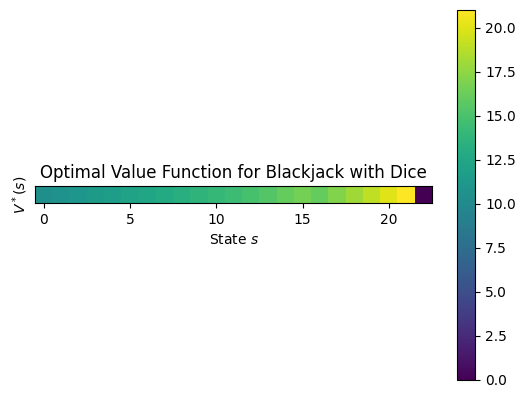

In [9]:
tmp = V.reshape(-1,1)
plt.imshow(tmp.T)
plt.xlabel("State $s$")
plt.ylabel("$V^*(s)$")
plt.yticks([])
plt.colorbar()
plt.title("Optimal Value Function for Blackjack with Dice")
plt.show()

## 2.3 Exercise 4: Get the optimal policy $\pi^*$ from $V^*$

Implement the class PolicyFromV. It takes as input an MDP and the associated $V^*$. In state $s$, $\pi^*(s)$ should return the action $a$ that leads to the next state $s'$ with highest value $V^*(s')$.

$\pi^*(s) = \underset{a}{\operatorname{argmax}}\left [ \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma V^{*}(s'))\right]$

In [10]:
class PolicyFromV(Policy):
    def __init__(self, mdp, V):
        super().__init__(mdp)
        self.V = V
        self.get_policy()

    def get_policy(self):
        self.policy = np.zeros(self.mdp.nb_states, dtype=int)

        for s in self.mdp.states:
            if s in self.mdp.terminal_states:
                continue

            # Compute value for each action
            action_values = []
            for a in self.mdp.actions:
                # Expected value: sum over next states
                value = 0
                for s_next in self.mdp.states:
                    value += self.mdp.P[s, a, s_next] * (self.mdp.R[s, a, s_next] + self.mdp.gamma * self.V[s_next])
                action_values.append(value)

            # Select action with highest value
            self.policy[s] = np.argmax(action_values)

    def get_action(self, state):
        return int(self.policy[state])


Compare the performances of $\pi^*$ with $\pi^{\text{unif}}$ and $\pi^{\text{thresh}}$ on 100 blackjack with dice games.

In [11]:
pol_opt = PolicyFromV(blackjack_dice, V).get_action

# Evaluate optimal policy on 100 episodes
policy_opt_eval = []
for episodes in range(100):
    policy_opt_eval.append(blackjack_dice.one_episode(pol_opt))

print("mean +- std of the score of the optimal policy: {:.2f} +/- {:.2f}".format(
    np.mean(policy_opt_eval), np.std(policy_opt_eval)))
print("mean +- std of the score of the threshold policy: {:.2f} +/- {:.2f}".format(
    np.mean(policy_thresh_eval), np.std(policy_thresh_eval)))
print("mean +- std of the score of the uniform policy: {:.2f} +/- {:.2f}".format(
    np.mean(policy_unif_eval), np.std(policy_unif_eval)))

mean +- std of the score of the optimal policy: 17.62 +/- 1.50
mean +- std of the score of the threshold policy: 16.58 +/- 1.52
mean +- std of the score of the uniform policy: 3.78 +/- 4.86


**Question**: Interpret your policy. Can you explain how your policy $\pi^*$ plays blackjack with dice?

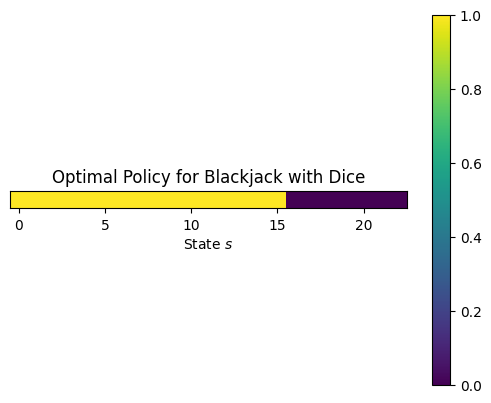

In [12]:
plt.imshow(np.array([pol_opt(s) for s in blackjack_dice.states]).reshape(1,-1))
plt.colorbar()
plt.title("Optimal Policy for Blackjack with Dice")
plt.yticks([])
plt.xlabel("State $s$")
plt.show()

## 2.4 State-action values $Q^{\pi}(s,a)$

Similarly to $V^{\pi}(s)$ it is possible to define the state-action value of $s,a$ when following policy $\pi$. The state-action value $Q^{\pi}(s,a)$ is the expected cumulative reward obtained by $\pi$ over MDP episodes when starting the episodes in $s_0 = s$ and choosing $a_0 = a$.

$Q^{\pi}(s,a) = \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma V^{\pi}(s'))$

We also have:

$Q^*(s,a) = \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma{\operatorname{max}}Q^*(s',a'))$

# 3. Reinforcement Learning

By contrast with dynamic programming, a reinforcement learning agent is used when the MDP is unknown. More precisely, the state and action are known, but the agent does not know the transition nor the reward function.

## 3.1 Q-Learning

The Q-learning algorithm learns an estimate $\hat{Q}$ of $Q^*$. It does so without an MDP transition probability model: it is a model-free RL algorithm. Q-learning collects transitions $(s,a,r,s')$ following a behaviour policy $\pi^B$. For each collected transition, $\hat{Q}$ is updated as follows:

$\hat{Q}(s,a) \leftarrow \hat{Q}(s,a) + \alpha \delta$

Where $\delta$ is the temporal difference error:

$r + \gamma \underset{a'}{\operatorname{max}}\hat{Q}(s',a') - \hat{Q}(s,a)$

The behaviour policy trades-off exploration and exploitation when collecting transitions in the MDP. For example, $\pi^B$ can be the epsilon-greedy policy:

$\pi^\epsilon(s) = \pi^{\text{unif}}$, with probability $\epsilon$

$\pi^\epsilon(s) = \underset{a}{\operatorname{argmax}}\hat{Q}(s, a), \text{ else }$

## 3.2 Exercise 5: Implement the Q-Learning algorithm

[Q-Learning algorithm](http://incompleteideas.net/book/ebook/node65.html)

In [ ]:
def QLearning(mdp, behaviour_pol, alpha=0.1, nb_iter=int(1e4)):
    """Q-Learning algorithm"""
    Qhat = np.zeros((mdp.nb_states, mdp.nb_actions))
    list_Qs = []
    s = mdp.reset()

    for _ in range(nb_iter):
        # Select action using behaviour policy
        a = behaviour_pol(s, Qhat)

        # Take action
        s_next, r, done = mdp.step(a)

        if done:
            # Terminal state: no future value
            Qhat[s, a] = r
            s = mdp.reset()
        else:
            # TODO: Implement TD update: Q(s,a) <- Q(s,a) + alpha * [r + gamma * max Q(s',a') - Q(s,a)]
            raise NotImplementedError

            list_Qs.append(Qhat.copy())
            s = s_next

    return Qhat, list_Qs

class EpsGreedyPolicy(Policy):
    def __init__(self, mdp, epsilon):
        self.mdp = mdp
        self.eps = epsilon

    def get_action(self, state, Q):
        if np.random.random() < self.eps:
            # Explore: random action
            return np.random.randint(self.mdp.nb_actions)
        else:
            # Exploit: best action
            return np.argmax(Q[state, :])


Try Q-Learning to learn an estimate of the optimal state-action value function of the blackjack with dice MDP.

- Visualize $\hat{Q}$ returned by Q-Learning (use $\texttt{plt.imshow()}$). Does this Q function make sense?
- Make a plot to compare the convergence of $\hat{Q}$ over iterations for different values of $\epsilon$ and different learning rates $\alpha$.
- Compare the performance of the greedy policy $\pi^{\text{greedy}}(s) = \underset{a}{\operatorname{argmax}}\hat{Q}(s, a)$ with other policies (uniform, threshold, $\pi^*$) on 100 episodes.

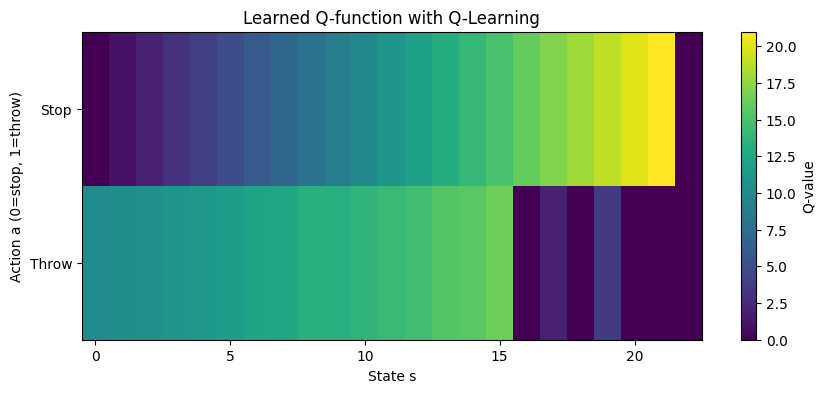

In [14]:
pol_behaviour = EpsGreedyPolicy(blackjack_dice, epsilon=0.3).get_action
q, list_Qs = QLearning(blackjack_dice, pol_behaviour, alpha=0.1, nb_iter=int(1e4))

# Visualize learned Q-function
plt.figure(figsize=(10, 4))
plt.imshow(q.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Q-value')
plt.xlabel('State s')
plt.ylabel('Action a (0=stop, 1=throw)')
plt.title('Learned Q-function with Q-Learning')
plt.yticks([0, 1], ['Stop', 'Throw'])
plt.show()

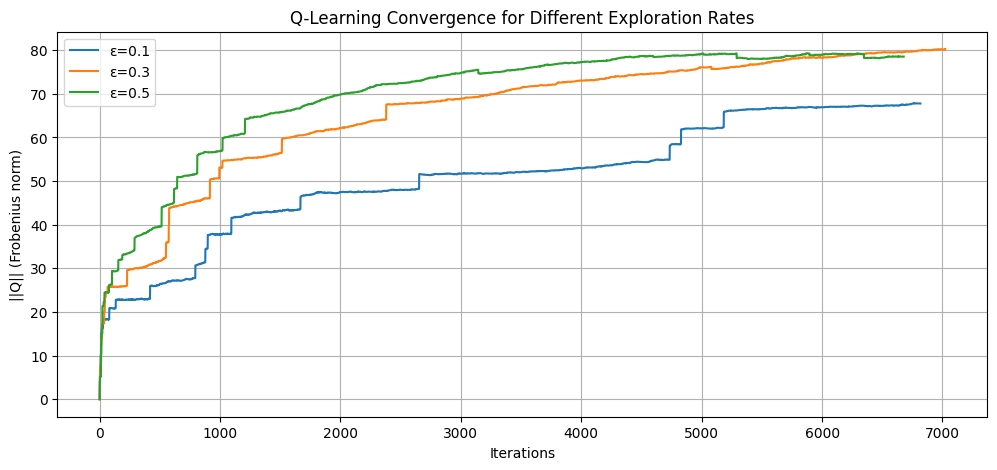

In [15]:
# Compare convergence for different epsilon values
plt.figure(figsize=(12, 5))

epsilons = [0.1, 0.3, 0.5]
for eps in epsilons:
    pol_behaviour = EpsGreedyPolicy(blackjack_dice, epsilon=eps).get_action
    q_temp, list_Qs_temp = QLearning(blackjack_dice, pol_behaviour, alpha=0.1, nb_iter=int(1e4))
    plt.plot([np.linalg.norm(q_i) for q_i in list_Qs_temp], label=f'ε={eps}')

plt.xlabel('Iterations')
plt.ylabel('||Q|| (Frobenius norm)')
plt.title('Q-Learning Convergence for Different Exploration Rates')
plt.legend()
plt.grid(True)
plt.show()

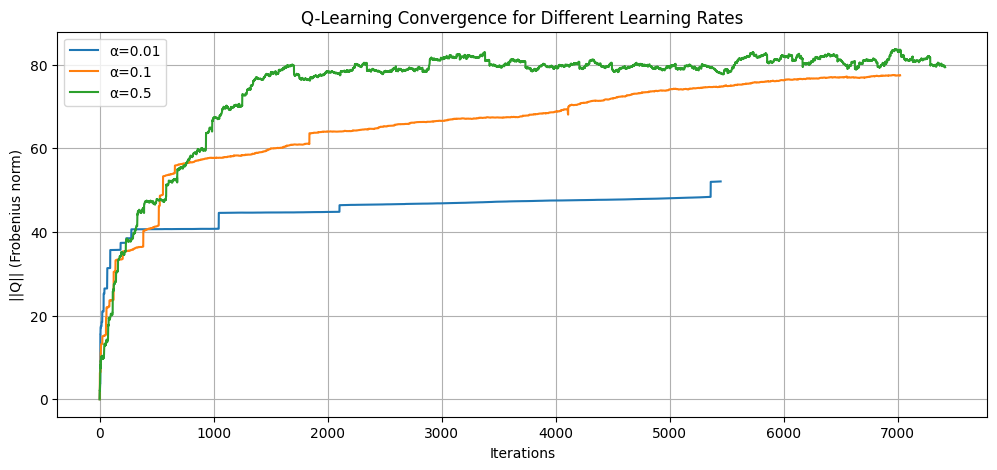

In [16]:
# Compare different learning rates
plt.figure(figsize=(12, 5))

alphas = [0.01, 0.1, 0.5]
for alpha in alphas:
    pol_behaviour = EpsGreedyPolicy(blackjack_dice, epsilon=0.3).get_action
    q_temp, list_Qs_temp = QLearning(blackjack_dice, pol_behaviour, alpha=alpha, nb_iter=int(1e4))
    plt.plot([np.linalg.norm(q_i) for q_i in list_Qs_temp], label=f'α={alpha}')

plt.xlabel('Iterations')
plt.ylabel('||Q|| (Frobenius norm)')
plt.title('Q-Learning Convergence for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Evaluate greedy policy from learned Q-function
class GreedyQPolicy(Policy):
    def __init__(self, mdp, Q):
        super().__init__(mdp)
        self.Q = Q
    
    def get_action(self, state):
        return int(np.argmax(self.Q[state, :]))

pol_greedy = GreedyQPolicy(blackjack_dice, q).get_action

policy_greedy_eval = []
for episodes in range(100):
    policy_greedy_eval.append(blackjack_dice.one_episode(pol_greedy))

print("\nPolicy Performance Comparison:")
print("=" * 50)
print("Greedy Q-Learning policy: {:.2f} +/- {:.2f}".format(
    np.mean(policy_greedy_eval), np.std(policy_greedy_eval)))
print("Optimal policy (from VI): {:.2f} +/- {:.2f}".format(
    np.mean(policy_opt_eval), np.std(policy_opt_eval)))
print("Threshold policy:         {:.2f} +/- {:.2f}".format(
    np.mean(policy_thresh_eval), np.std(policy_thresh_eval)))
print("Uniform policy:           {:.2f} +/- {:.2f}".format(
    np.mean(policy_unif_eval), np.std(policy_unif_eval)))


Policy Performance Comparison:
Greedy Q-Learning policy: 17.58 +/- 1.40
Optimal policy (from VI): 17.62 +/- 1.50
Threshold policy:         16.58 +/- 1.52
Uniform policy:           3.78 +/- 4.86


# 4. Homework: Maze MDPs and Reinforcement Learning

This homework is open to interpretation and implementation. You can work in pairs.

**Deadline**: December 3rd, 2025. Send your report to [thomas.michel@inria.fr](mailto:thomas.michel@inria.fr)

### Exercise 1: Implement a Maze MDP Generator

Mazes are often used to benchmark new RL algorithms. One can think of a maze MDP as a rectangle divided into cells. Each cell is a MDP state. The upper left cell is the initial state and the bottom right is the exit. Walls should be placed at random in the MDP: this will be done by specifying a fraction of cell states that are non-accessible. There are 4 actions in a maze MDP: left, right, up, down. All state-action pairs give a 0 reward, except a state-action pair that leads to the exit (terminal) state in the bottom right cell.

- How to make sure that a generated maze can be exited? You can try checking $V^*(s_{start}) > 0$.
- Your Maze MDP generator should take as arguments: a width, a height, and a fraction of cell walls. $|S| = \text{width} \times \text{height}$.

### Exercise 2: 3-Page Report on Q-Learning Performance

Present the performances of Q-Learning on maze MDPs:

- Check that your learned Q functions make sense on some examples.
- Compare eps-greedy policy and softmax behaviour policy.
- Try changing the parameters of those policies, as well as the size and difficulty of the maze MDPs. What can you observe? Can you explain it?
- Can you suggest/implement improvements to the algorithm?

**Note**: In general, describe your experiments and do not put too many figures (choose a few convincing figures) and then describe what you observe and try to understand if it makes sense.